# ANÁLISIS EXPLORATORIO DE DATOS Y PRIMERA VERSIÓN DEL CLASIFICADOR DE VEHÍCULOS DAÑADOS

#### Con este script se pretende hacer un análisis exploratorio de la base de datos de imágenes de vehículos utilizada. 

#### A su vez, se hace una primera iteración del clasificador de vehículos dañados, mediante una red convolucional. En los siguientes scripts se mejorará este clasificador usando un modelo pre-entrenado.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import cv2
import os, sys
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
os.chdir("/content/drive/MyDrive/MasterMBD/ProyectoIMAGEN/CarInsurance") 
sys.path.append("/content/drive/MyDrive/MasterMBD/ProyectoIMAGEN/CarInsurance") 

In [2]:
train_dir = "training"
test_dir = "validation"

In [3]:
print("Train set:")
print("-"*60)
num_damage = len(os.listdir(os.path.join(train_dir, '00-damage')))
num_whole = len(os.listdir(os.path.join(train_dir, '01-whole')))
print(f"Dañados={num_damage}")
print(f"Normal={num_whole}")

Train set:
------------------------------------------------------------
Dañados=920
Normal=920


In [4]:
print("\nTest set:")
print('-'*60)
print(f"Dañados={len(os.listdir(os.path.join(test_dir, '00-damage')))}")
print(f"Normal={len(os.listdir(os.path.join(test_dir, '01-whole')))}")


Test set:
------------------------------------------------------------
Dañados=230
Normal=230


Se comprueba que tanto el dataset de training, como el de test están balanceados

In [5]:
DAMAGE = os.listdir("training/00-damage")
DAMAGE_dir = "training/00-damage"
# Train Normal 
NORMAL = os.listdir("training/01-whole")
NORMAL_dir = "training/01-whole"

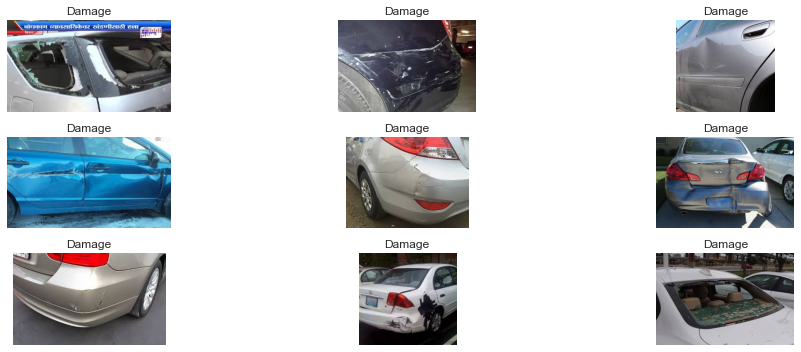

In [6]:
# Enseñar las imágenes de coches dañados
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(DAMAGE_dir, DAMAGE[i]))
    plt.title("Damage")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

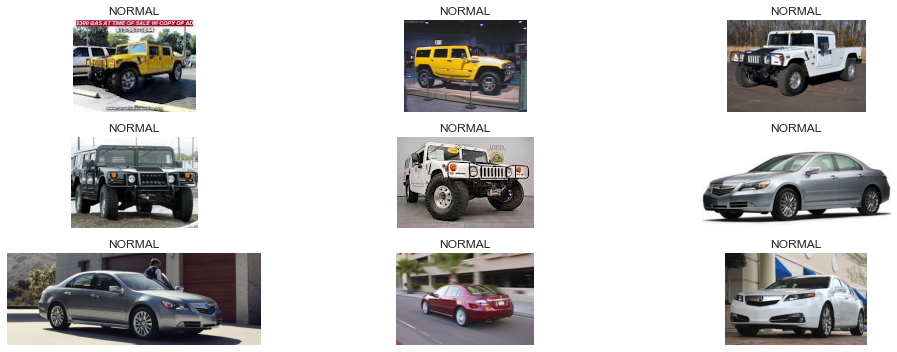

In [7]:
# SHOW NORMAL image
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(NORMAL_dir, NORMAL[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

In [8]:
# Función para procesar y hacer el resize de las imágenes
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


labels = ['00-damage', '01-whole']
img_size = 200

In [9]:
train = get_training_data(train_dir)
test = get_training_data(test_dir)

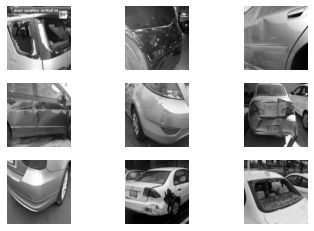

In [10]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train[i][0], cmap="gray")
    plt.axis('off')

In [11]:
from sklearn.model_selection import train_test_split

X = []
y = []
for feature, label in train:
    X.append(feature)
    y.append(label)
    
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [12]:
print("shape X_train: ", X_train.shape)
print("shape y_train: ", y_train.shape)
print("sahpe X_test: ", X_test.shape)
print("shape y_test: ", y_test.shape)

shape X_train:  (1472, 200, 200, 1)
shape y_train:  (1472,)
sahpe X_test:  (368, 200, 200, 1)
shape y_test:  (368,)


In [13]:
X_train = X_train.reshape(1472, img_size**2)

X_test = X_test.reshape(368, img_size**2)

#normalize data
X_train = X_train / 255
X_test = X_test / 255

In [14]:
print(X_train[0])

[0.18823529 0.2        0.33333333 ... 0.75686275 0.74117647 0.7254902 ]


In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1472, 40000)
(368, 40000)
(1472,)
(368,)


## MODELO 1: Construir el primer modelo

#### DISCLAIMER: Este proceso de construcción de modelos es largo (algunos entrenamientos tardan 45 minutos). 

#### ¡¡ Se puede avanzar al siguiente script 02.1_DamagedOrNot.ipynb !!

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Flatten, Activation

model = Sequential()

model.add(Dense(1024,input_shape=(40000,),activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

#adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.build()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              40961024  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 42,798,593
Trainable params: 42,798,593
Non-trainable params: 0
_________________________________________________________________


## Entrenar nuestro modelo

In [19]:
tic=time.time()
history_01 = model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=15)

# model.save('models/model01.h5') 
print('seconds=', time.time()-tic)

Epoch 1/15
12/12 [==============================] - 3s 243ms/step - loss: 1.2042 - acc: 0.4946 - val_loss: 0.7013 - val_acc: 0.5000
Epoch 2/15
12/12 [==============================] - 3s 228ms/step - loss: 0.6968 - acc: 0.5360 - val_loss: 0.6866 - val_acc: 0.5788
Epoch 3/15
12/12 [==============================] - 3s 247ms/step - loss: 0.6718 - acc: 0.5863 - val_loss: 0.7062 - val_acc: 0.5109
Epoch 4/15
12/12 [==============================] - 3s 238ms/step - loss: 0.6603 - acc: 0.6101 - val_loss: 0.7266 - val_acc: 0.5380
Epoch 5/15
12/12 [==============================] - 3s 258ms/step - loss: 0.6499 - acc: 0.6039 - val_loss: 0.6832 - val_acc: 0.5815
Epoch 6/15
12/12 [==============================] - 3s 240ms/step - loss: 0.6429 - acc: 0.6162 - val_loss: 0.7451 - val_acc: 0.5353
Epoch 7/15
12/12 [==============================] - 3s 245ms/step - loss: 0.6634 - acc: 0.6080 - val_loss: 0.6849 - val_acc: 0.5924
Epoch 8/15
12/12 [==============================] - 3s 246ms/step - loss: 0.

## Representar gráficamente las pérdidas y la accuracy

In [20]:
# Hacer gráficas de los resultados
acc = history_01.history['acc']
val_acc = history_01.history['val_acc'] 
loss = history_01.history['loss'] 
val_loss = history_01.history['val_loss']

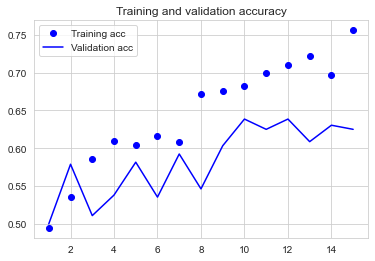

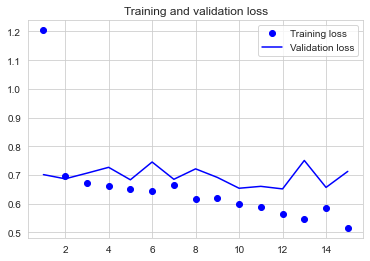

In [21]:
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

En los gráficos superiores se observa que, a medida que aumentan las épocas aumenta la accuracy del modelo y disminuye el valor para la función de pérdida. Sin embargo, se puede apreciar cierto overfitting que nos replantearía el ajuste de parámetros o el cambio a otro modelo más adecuado.

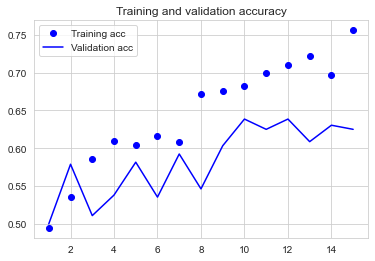

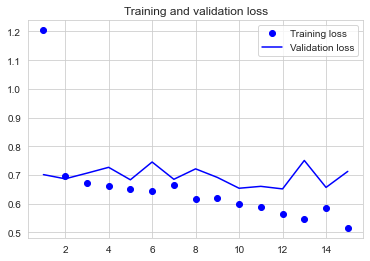

In [22]:
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

Otra manera visual de ver de un modo conjunto los valores para loss y accuracy es la siguiente:

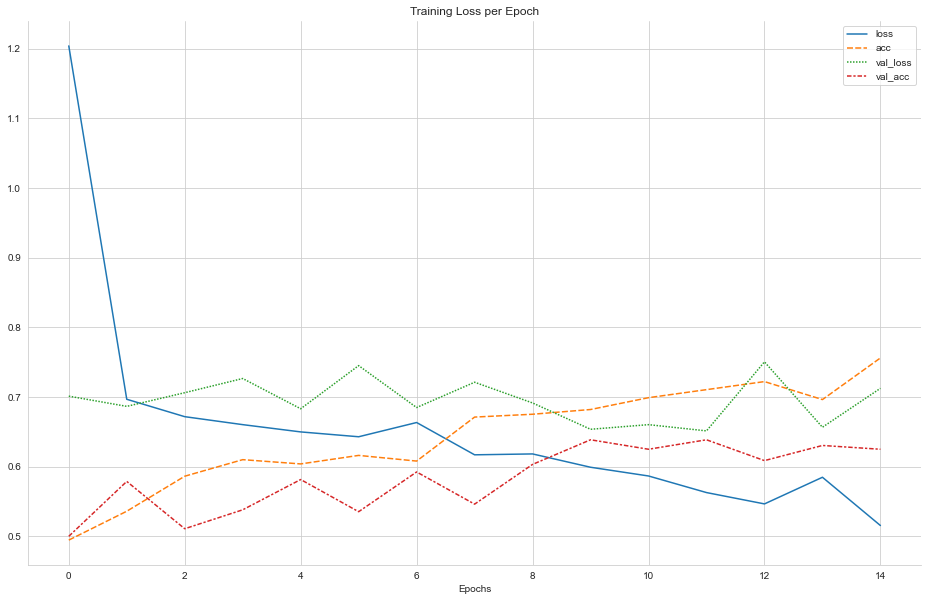

In [23]:
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(16,10))
sns.lineplot(data=losses)
plt.xlabel('Epochs')

plt.title('Training Loss per Epoch')
sns.despine()

## Calcular el error medio absoluto de nuestro entrenamiento

In [24]:
from sklearn.metrics import mean_absolute_error

predictions = model.predict(X_test)
print('MAE: ',mean_absolute_error(y_test,predictions))

MAE:  0.4190146318920281


## MODELO 2: Construir el segundo modelo

En este segundo modelo se prueba a incluir las capas convolucionales:

In [25]:
cwd = os.getcwd()
base_dir = cwd

In [26]:
# directories for datsets
train_dir = os.path.join(base_dir, 'training') 
validation_dir = os.path.join(base_dir, 'validation') 

# Training whole and damaged directories
train_damage_dir = os.path.join(train_dir, '00-damage') 
train_whole_dir = os.path.join(train_dir, '01-whole') 

# whole and damaged validation directories
validation_damage_dir = os.path.join(validation_dir, '00-damage') 
validation_whole_dir = os.path.join(validation_dir, '01-whole')

In [27]:
import os

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

In [29]:
# Resume del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [30]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [31]:
# Configure images for training. 
train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, # directorio con datos
                                                    target_size=(150, 150), # imágenes a 150x150
                                                    batch_size=20, # imágenes generadas por lote
                                                    class_mode='binary')# dado que es clasificación es binaria
validation_generator = test_datagen.flow_from_directory(validation_dir,target_size=(150, 150), batch_size=20, class_mode='binary')

for data_batch, labels_batch in train_generator:
    print('Dimensiones del lote de datos:', data_batch.shape)
    print('Dimensiones del lote de etiquetas:', labels_batch.shape)
    break

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Dimensiones del lote de datos: (20, 150, 150, 3)
Dimensiones del lote de etiquetas: (20,)


El generator funciona de la siguinete manera:

Parámetros:
**generator**, instancia de un generador Keras, la salida del generador debe ser una de:

una tupla (inputs, targets)

una tupla (inputs, targets, sample_weights).

El generador se ejecuta en paralelo con el entrenamiento y permite hacer aumento de datos en tiempo real (usar use_multiprocessing=True): aumentado de datos en CPU y entrenamiento en GPU.

**steps_per_epoch**: int, número total de pasos (lotes de muestras) para detener el generador
epochs: Hace que el entrenamiento termine después del número determinado de épocas.

**validation_data**: Puede ser un generador o una secuencia del mismo formato que los datos

**validation_steps**: Si validation_data is a generator es el número total de pasos para detener el generador de datos de validación antes detenerse por el fin de cada época. Típicamente igual a número de muetras de validación dividido por el tamaño del lote.

**class_weight**: idem

**max_queue_size**: int, tamaño máximo de la cola del generador

**shuffle**: idem.

**workers**: int, máximo número de procesos (útil para generar en paralelo)

**use_multiprocessing**: boleano, si True, usar múltiples procesos

**initial_epoch**: int, época para inicar el entrenamiento, útil para continuar entrenamientos parciales

**callbacks**: idem

**verbose**: int: 0 = silencio, 1 = barra de progreso, 2 = una línea por época.

In [32]:
# Fit the model using batch generator and save
tic=time.time()

history_02 = model.fit_generator(generator        =train_generator, 
                              steps_per_epoch  =90, 
                              epochs           =15, 
                              validation_data  =validation_generator, 
                              validation_steps =50,
                              verbose          =2, # int: 0 = silencio, 1 = barra de progreso, 2 = una línea por época.
                              max_queue_size   =12,
                              workers          =12)
                              #use_multiprocessing=True)

model.save('models/damaged_or_whole.h5')

print('seconds=', time.time()-tic)

Epoch 1/15
90/90 - 42s - loss: 0.6652 - acc: 0.5883 - val_loss: 0.6216 - val_acc: 0.6370
Epoch 2/15
90/90 - 45s - loss: 0.5932 - acc: 0.6828 - val_loss: 0.5900 - val_acc: 0.6780
Epoch 3/15
90/90 - 44s - loss: 0.5500 - acc: 0.7156 - val_loss: 0.5472 - val_acc: 0.7290
Epoch 4/15
90/90 - 48s - loss: 0.5081 - acc: 0.7533 - val_loss: 0.5169 - val_acc: 0.7460
Epoch 5/15
90/90 - 48s - loss: 0.4695 - acc: 0.7850 - val_loss: 0.5022 - val_acc: 0.7360
Epoch 6/15
90/90 - 55s - loss: 0.4273 - acc: 0.8094 - val_loss: 0.5382 - val_acc: 0.7480
Epoch 7/15
90/90 - 58s - loss: 0.3940 - acc: 0.8367 - val_loss: 0.4540 - val_acc: 0.7810
Epoch 8/15
90/90 - 57s - loss: 0.3735 - acc: 0.8344 - val_loss: 0.4727 - val_acc: 0.7750
Epoch 9/15
90/90 - 56s - loss: 0.3469 - acc: 0.8561 - val_loss: 0.4543 - val_acc: 0.7860
Epoch 10/15
90/90 - 56s - loss: 0.3166 - acc: 0.8678 - val_loss: 0.4447 - val_acc: 0.7900
Epoch 11/15
90/90 - 53s - loss: 0.2864 - acc: 0.8811 - val_loss: 0.5274 - val_acc: 0.7670
Epoch 12/15
90/90 -

In [33]:
# Plot the results
acc = history_02.history['acc']
val_acc = history_02.history['val_acc'] 
loss = history_02.history['loss'] 
val_loss = history_02.history['val_loss']

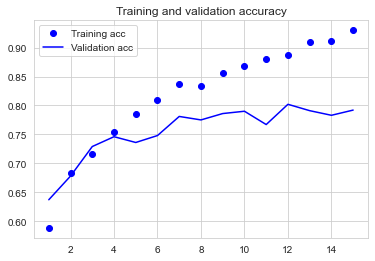

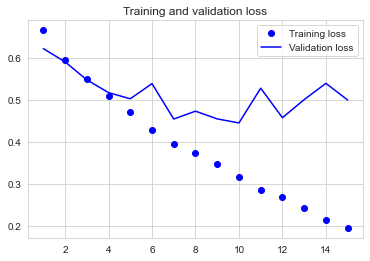

In [34]:
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Data Augmentation

Con el uso de data augmentation generamos más datos de entrenamiento aumentando las muestras para crear imágenes nuevas falsas. Estas imágenes se generan por transformaciones aleatorias.

La idea es "crear" nuevos datos para reducir overfitting.

In [35]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

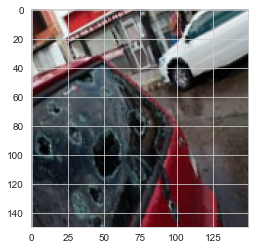

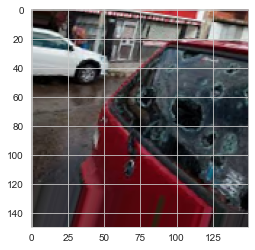

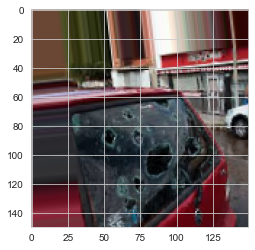

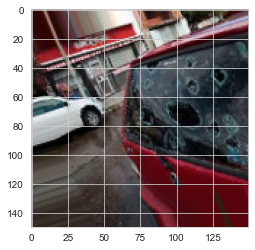

In [37]:
# Generate example images
fnames = [os.path.join(train_damage_dir, fname) for fname in os.listdir(train_damage_dir)]

img_path = fnames[100] # Choose image to augment
img = image.load_img(img_path, target_size=(150, 150)) # read and resize image
x = image.img_to_array(img) # Convert to numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape) # reshape to (1, 150, 150, 3)

# Generates batches of randomly transformed images. 
# Loops indefinitely, so you need to break the loop at some point!
i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0])) 
    i += 1
    if i % 4 == 0:
        break 
plt.show()

### Dropout

#### Al igual que "data augmentation", el modelo se intenta mejorar añadiendo Dropout.

In [38]:
# Construir modelo con dropout
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [39]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

# Training the convnet using data-augmentation generators and save
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, 
                                                    class_mode='binary') # binary labels for binary_crossentropy

validation_generator = test_datagen.flow_from_directory(validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

tic=time.time()
history_03 = model.fit_generator(generator        =train_generator, 
                              steps_per_epoch  =50, 
                              epochs           =30, 
                              validation_data  =validation_generator, 
                              validation_steps =50,
                              verbose          =2, # int: 0 = silencio, 1 = barra de progreso, 2 = una línea por época.
                              max_queue_size   =12,
                              workers          =12)
                              #use_multiprocessing=True)


model.save('models/damaged_or_whole_2.h5')
print('seconds=', time.time()-tic) ## 45 min de ejecución

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/30
50/50 - 51s - loss: 0.6955 - acc: 0.5095 - val_loss: 0.6796 - val_acc: 0.5857
Epoch 2/30
50/50 - 54s - loss: 0.6755 - acc: 0.5731 - val_loss: 0.6640 - val_acc: 0.5929
Epoch 3/30
50/50 - 55s - loss: 0.6614 - acc: 0.5979 - val_loss: 0.6641 - val_acc: 0.5994
Epoch 4/30
50/50 - 52s - loss: 0.6553 - acc: 0.6086 - val_loss: 0.6545 - val_acc: 0.6208
Epoch 5/30
50/50 - 53s - loss: 0.6404 - acc: 0.6427 - val_loss: 0.6340 - val_acc: 0.6364
Epoch 6/30
50/50 - 51s - loss: 0.6398 - acc: 0.6338 - val_loss: 0.6361 - val_acc: 0.6260
Epoch 7/30
50/50 - 51s - loss: 0.6391 - acc: 0.6490 - val_loss: 0.6322 - val_acc: 0.6442
Epoch 8/30
50/50 - 55s - loss: 0.6288 - acc: 0.6490 - val_loss: 0.7349 - val_acc: 0.5903
Epoch 9/30
50/50 - 51s - loss: 0.6249 - acc: 0.6667 - val_loss: 0.6107 - val_acc: 0.6584
Epoch 10/30
50/50 - 55s - loss: 0.6187 - acc: 0.6711 - val_loss: 0.6149 - val_acc: 0.6571
Epoch 11/30
50/50 - 55s - 

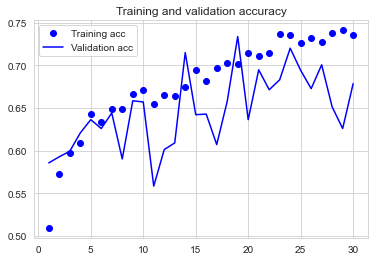

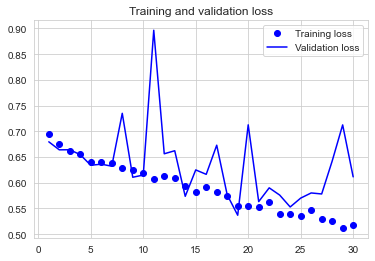

In [40]:
acc = history_03.history['acc']
val_acc = history_03.history['val_acc'] 
loss = history_03.history['loss'] 
val_loss = history_03.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [41]:
# This time with more epochs
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

# Training the convnet using data-augmentation generators and save
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, 
                                                    class_mode='binary') # binary labels for binary_crossentropy

validation_generator = test_datagen.flow_from_directory(validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')


tic=time.time()
history_04 = model.fit_generator(generator        =train_generator, 
                              steps_per_epoch  =50, 
                              epochs           =60, 
                              validation_data  =validation_generator, 
                              validation_steps =50,
                              verbose          =2, # int: 0 = silencio, 1 = barra de progreso, 2 = una línea por época.
                              max_queue_size   =12,
                              workers          =12)
                              #use_multiprocessing=True)


model.save('models/damaged_or_whole_3.h5')
print('seconds=', time.time()-tic)

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/60
50/50 - 47s - loss: 0.5122 - acc: 0.7487 - val_loss: 0.7090 - val_acc: 0.6429
Epoch 2/60
50/50 - 50s - loss: 0.5156 - acc: 0.7418 - val_loss: 0.8912 - val_acc: 0.5922
Epoch 3/60
50/50 - 46s - loss: 0.5129 - acc: 0.7519 - val_loss: 0.5802 - val_acc: 0.7195
Epoch 4/60
50/50 - 51s - loss: 0.5194 - acc: 0.7325 - val_loss: 0.5139 - val_acc: 0.7571
Epoch 5/60
50/50 - 48s - loss: 0.5026 - acc: 0.7556 - val_loss: 0.6510 - val_acc: 0.6792
Epoch 6/60
50/50 - 48s - loss: 0.5150 - acc: 0.7348 - val_loss: 0.6925 - val_acc: 0.6708
Epoch 7/60
50/50 - 50s - loss: 0.5010 - acc: 0.7588 - val_loss: 0.7514 - val_acc: 0.6506
Epoch 8/60
50/50 - 46s - loss: 0.4981 - acc: 0.7544 - val_loss: 0.5934 - val_acc: 0.7104
Epoch 9/60
50/50 - 50s - loss: 0.5001 - acc: 0.7614 - val_loss: 0.5364 - val_acc: 0.7442
Epoch 10/60
50/50 - 49s - loss: 0.4977 - acc: 0.7481 - val_loss: 0.7987 - val_acc: 0.6416
Epoch 11/60
50/50 - 48s - 

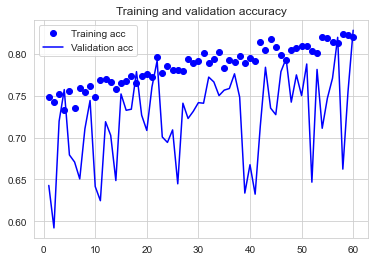

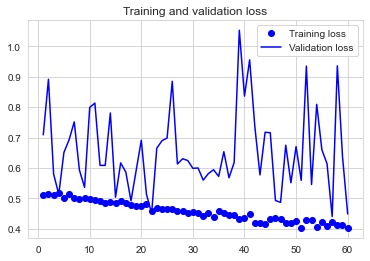

In [42]:
acc = history_04.history['acc']
val_acc = history_04.history['val_acc'] 
loss = history_04.history['loss'] 
val_loss = history_04.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [43]:
# Ahora incluimos más epochs
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

# Training the convnet using data-augmentation generators and save
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, 
                                                    class_mode='binary') # binary labels for binary_crossentropy

validation_generator = test_datagen.flow_from_directory(validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')



tic=time.time()
history_05 = model.fit_generator(generator        =train_generator, 
                              steps_per_epoch  =50, 
                              epochs           =120, 
                              validation_data  =validation_generator, 
                              validation_steps =50,
                              verbose          =2, # int: 0 = silencio, 1 = barra de progreso, 2 = una línea por época.
                              max_queue_size   =12,
                              workers          =12)
                              #use_multiprocessing=True)

model.save('models/damaged_or_whole_4.h5')
print('seconds=', time.time()-tic)

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/120
50/50 - 47s - loss: 0.4192 - acc: 0.8074 - val_loss: 1.5325 - val_acc: 0.5721
Epoch 2/120
50/50 - 46s - loss: 0.4120 - acc: 0.8176 - val_loss: 0.4854 - val_acc: 0.8162
Epoch 3/120
50/50 - 48s - loss: 0.4027 - acc: 0.8157 - val_loss: 0.6646 - val_acc: 0.7760
Epoch 4/120
50/50 - 47s - loss: 0.4158 - acc: 0.8157 - val_loss: 0.8423 - val_acc: 0.7013
Epoch 5/120
50/50 - 46s - loss: 0.4132 - acc: 0.8138 - val_loss: 0.8840 - val_acc: 0.7032
Epoch 6/120
50/50 - 49s - loss: 0.4291 - acc: 0.8081 - val_loss: 0.5308 - val_acc: 0.7903
Epoch 7/120
50/50 - 50s - loss: 0.3999 - acc: 0.8295 - val_loss: 0.7700 - val_acc: 0.7435
Epoch 8/120
50/50 - 46s - loss: 0.4049 - acc: 0.8176 - val_loss: 0.4869 - val_acc: 0.8097
Epoch 9/120
50/50 - 49s - loss: 0.4134 - acc: 0.8100 - val_loss: 1.1573 - val_acc: 0.6448
Epoch 10/120
50/50 - 47s - loss: 0.4201 - acc: 0.8062 - val_loss: 0.5938 - val_acc: 0.7643
Epoch 11/120
50/

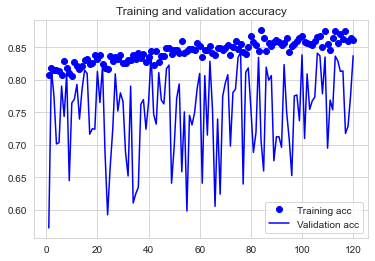

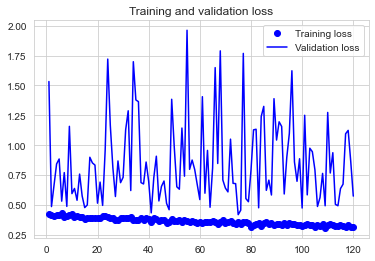

In [44]:
acc = history_05.history['acc']
val_acc = history_05.history['val_acc'] 
loss = history_05.history['loss'] 
val_loss = history_05.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

Tal y como se puede observar en todos los gráficos anteriores, en el conjunto de validación, los valores de accuracy y pérdida son muy variables, no se converge a ningún valor. Por esta razón, es importante probar con modelos pre-entrenados.